In [1]:
import os
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingRegressor

In [2]:
HEROKU_URL = os.getenv('HEROKU_POSTGRESQL_AMBER_URL')

uri = HEROKU_URL 
if uri.startswith("postgres://"):
    uri = uri.replace("postgres://", "postgresql://", 1)

df_raw = pd.read_sql('petfinder_with_dates', uri)  

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# dropping irrelevant columns
df_raw = df_raw.drop(columns=["id", "name", "organization_id", "published_at", "status_changed_at", "attribute_declawed", "city", "state"])

In [5]:
# Print unique values in 'age' column before fillna()
print(df_raw['age'].unique())

# Fill NaN values in 'age' column with 'Unknown'
df_raw['age'].fillna('Unknown', inplace=True)

# Print unique values in 'age' column after fillna()
print(df_raw['age'].unique())

['Young' 'Adult' 'Baby' 'Senior']
['Young' 'Adult' 'Baby' 'Senior']


In [6]:
# transform "age" column mapping age and size
age_dict={
'Baby':'0',
'Young':'1',
'Adult':'2',
'Senior':'3'
}
df_raw['age'] = df_raw['age'].map(age_dict).astype(str).astype(int)

In [7]:
# transform "size" column
size_dict={
'Small':'0',
'Medium':'1',
'Large': '2',
'Extra Large': '3'
}
df_raw['size'] = df_raw['size'].map(size_dict).astype(str).astype(int)

In [8]:
# Convert binary columns to binary (0/1) data type
binary_cols = ["breed_mixed", "breed_unknown", "good_with_children", "good_with_dogs", "good_with_cats", "attribute_spayed_neutered",
               "attribute_house_trained", "attribute_shots_current", "attribute_special_needs"]
df_raw[binary_cols] = df_raw[binary_cols].astype(bool).astype(int)

In [9]:
# Replace 'Male' and 'Female' with 0 and 1, respectively
df_raw['gender'] = df_raw['gender'].replace({"Male": 0, "Female": 1})

# Compute the mode of the 'gender' column, ignoring 'Unknown'
mode = df_raw.loc[df_raw['gender'] != 'Unknown', 'gender'].mode()[0]

# Replace 'Unknown' values with the mode
df_raw['gender'] = df_raw['gender'].replace({'Unknown': mode})

In [10]:
# target encoding on larger categorical features
target_cols = ["coat", "organization_name", "breed_primary", "breed_secondary", "color_primary", "color_secondary", "color_tertiary"]
te = ce.TargetEncoder(cols=target_cols)
df_raw[target_cols] = te.fit_transform(df_raw[target_cols], df_raw["los"])

In [11]:
def remove_outliers(dataframe, columns):
    for col in columns:
        mean = dataframe[col].mean()
        std = dataframe[col].std()
        z_scores = np.abs((dataframe[col] - mean) / std)
        dataframe = dataframe[z_scores <= 3]
    return dataframe

# Remove outliers from Carats, Price, and Retail using Z-score
df_raw = remove_outliers(df_raw, ['organization_name', 'los', 'breed_primary', 'breed_secondary'])

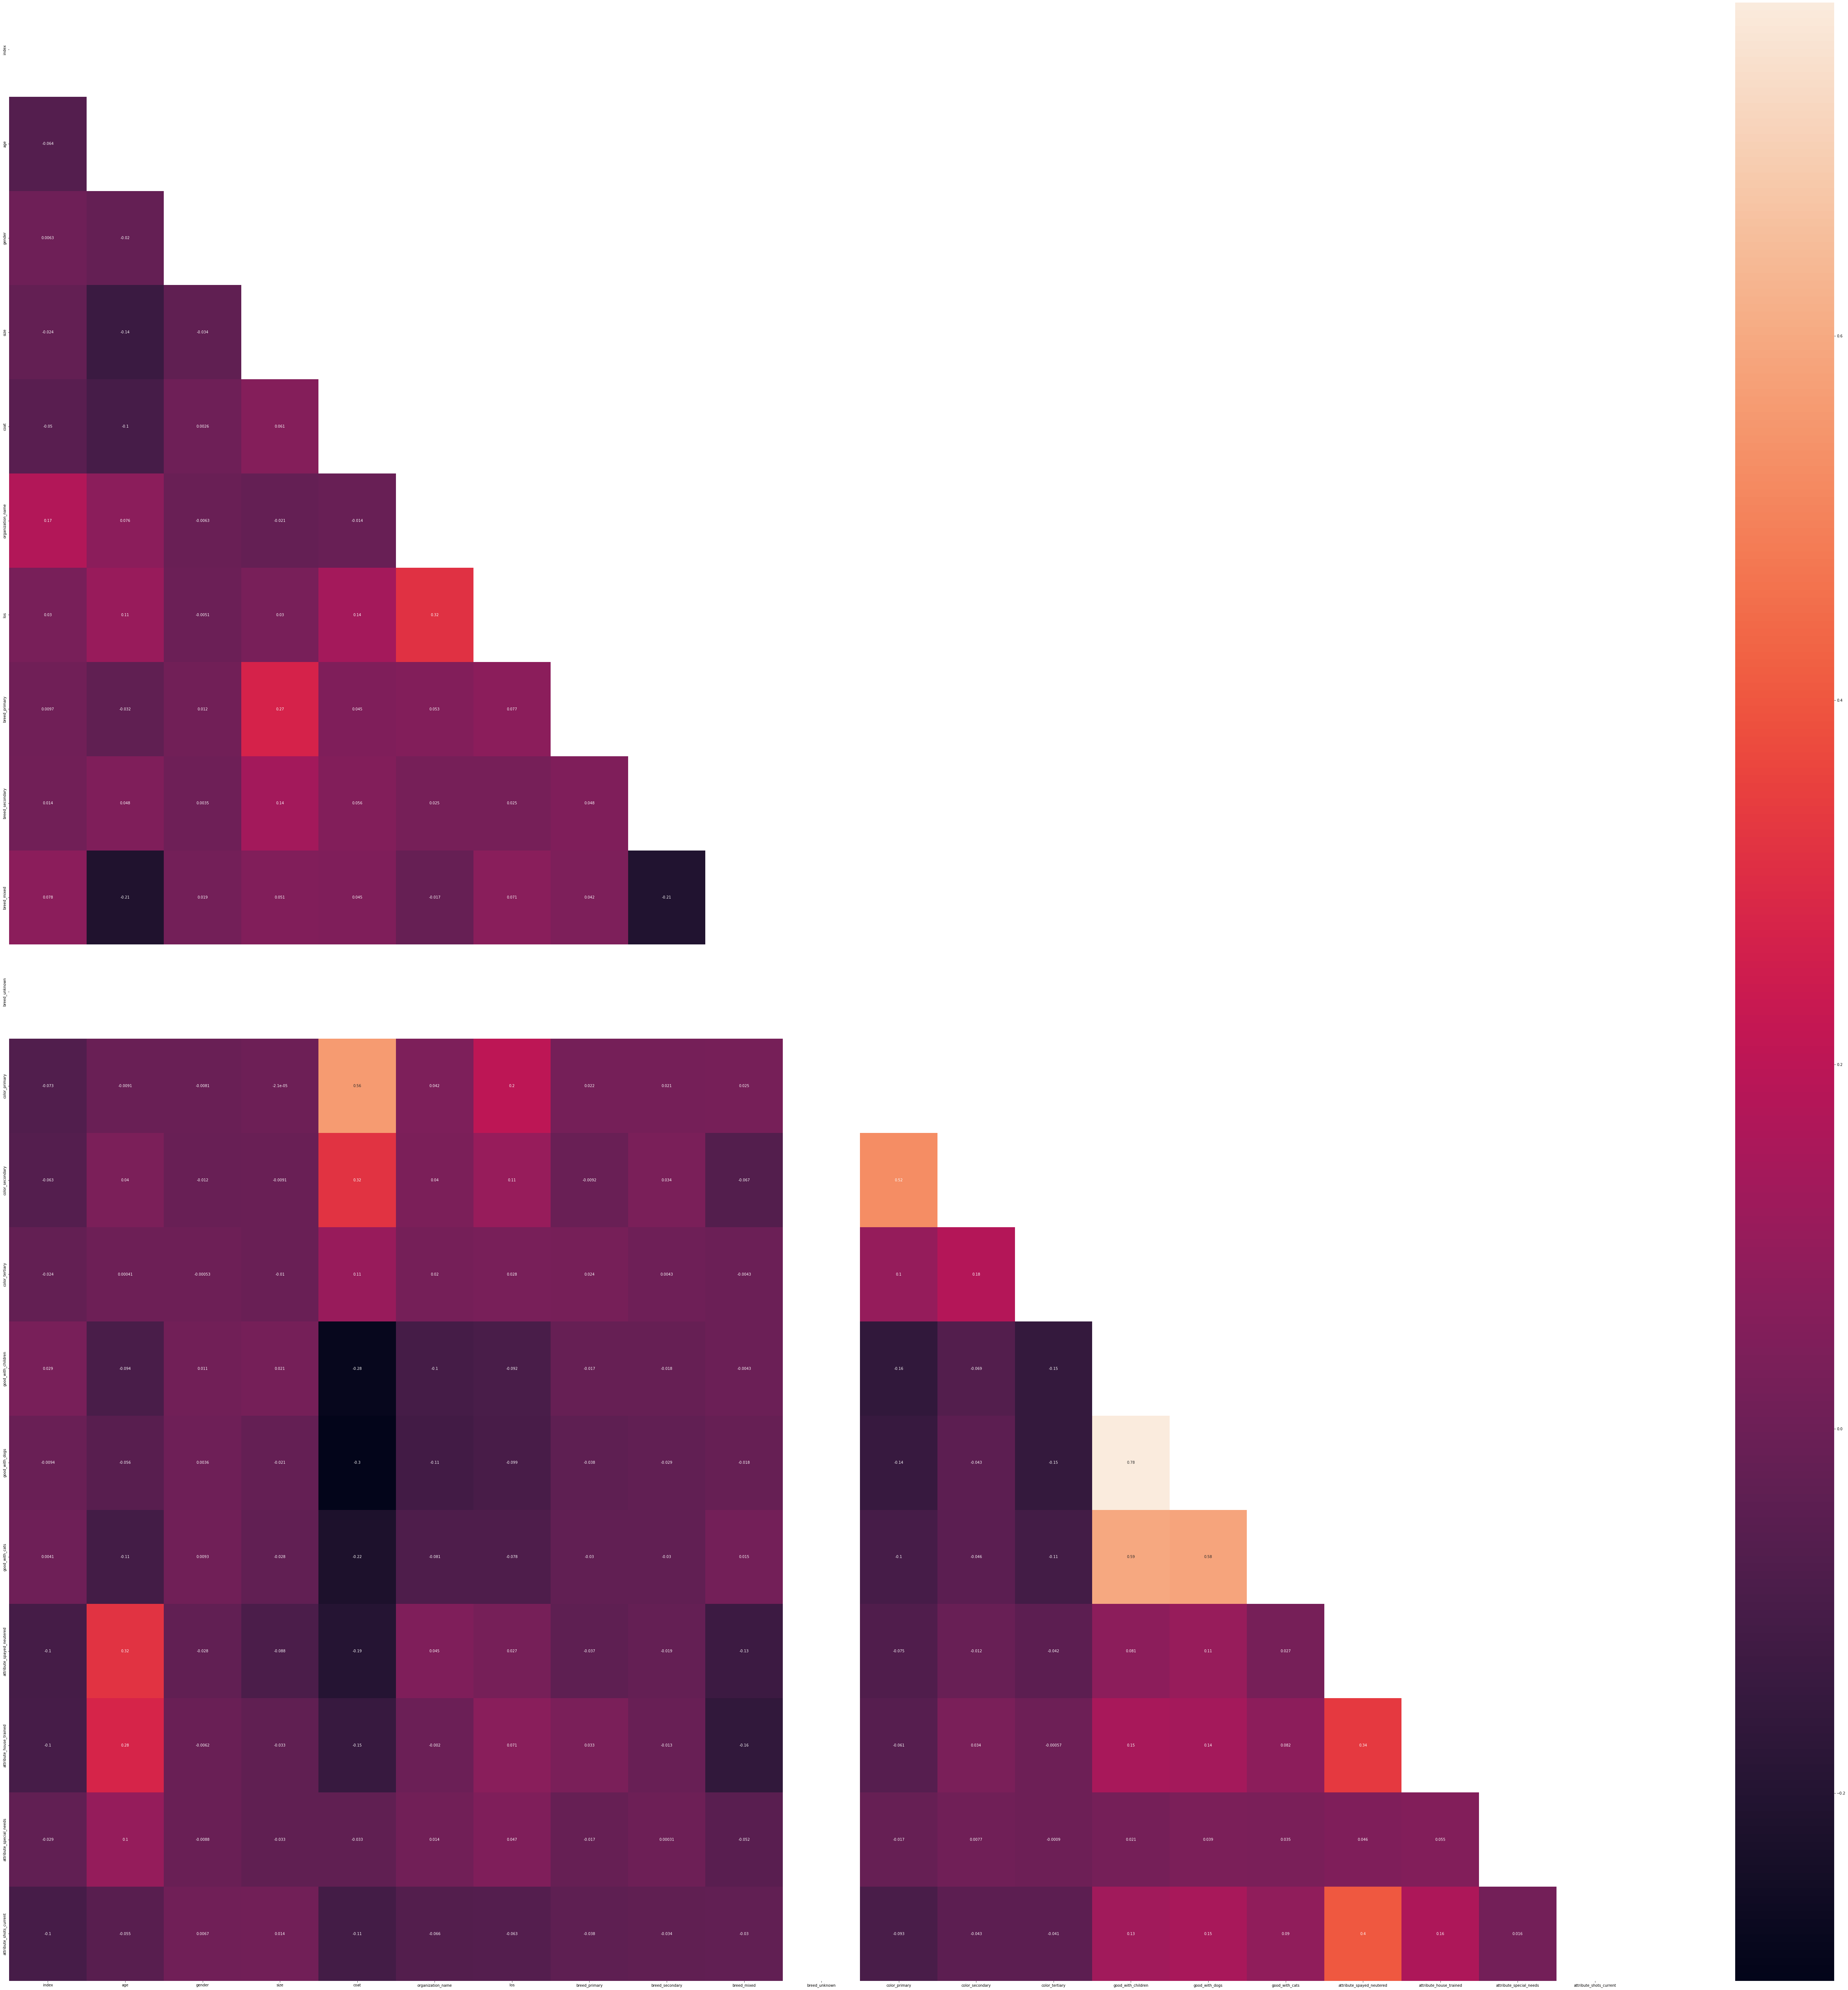

In [12]:
# high level plot of heatmap
import seaborn as sns


corr = df_raw.corr()
f, ax = plt.subplots(figsize=(100,100))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,annot = True, mask = mask)
plt.show()

In [13]:
def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [14]:
to_drop = identify_correlated(df_raw, threshold=.5)

In [15]:
print(to_drop)

['coat', 'color_primary', 'good_with_children', 'good_with_dogs']


In [16]:
df_raw = pd.DataFrame(df_raw.drop(to_drop, axis=1))

In [17]:
for col in df_raw.columns:
    print(col)

index
age
gender
size
organization_name
los
breed_primary
breed_secondary
breed_mixed
breed_unknown
color_secondary
color_tertiary
good_with_cats
attribute_spayed_neutered
attribute_house_trained
attribute_special_needs
attribute_shots_current


In [18]:
# # need to figure out how to pre process these fields
# df_raw = df_raw.drop(['city', 'state'], axis=1)

In [19]:
y = df_raw["los"]

features = []
for col in df_raw.columns:
    if col != "los":  # Skip the 'Target' column if it exists
        features.append(col)

X = df_raw[features]


In [20]:
X.head()

,index,age,gender,size,organization_name,breed_primary,breed_secondary,breed_mixed,breed_unknown,color_secondary,color_tertiary,good_with_cats,attribute_spayed_neutered,attribute_house_trained,attribute_special_needs,attribute_shots_current
0,0,1,1,0,74.791123,85.870573,87.105080,1,0,154.397827,119.185699,0,1,1,0,1
1,1,1,1,0,74.791123,85.197057,122.791397,0,0,50.745709,119.185699,0,1,0,0,1
2,2,2,0,0,74.791123,55.136602,87.105080,1,0,154.397827,119.185699,0,1,1,0,1
3,3,2,0,0,74.791123,94.308400,122.791397,0,0,154.397827,119.185699,0,1,1,0,1
4,4,2,0,2,74.791123,132.077141,122.791397,0,0,154.397827,119.185699,0,1,1,0,1


In [21]:
to_drop = identify_correlated(X, threshold=.2)

In [22]:
X = pd.DataFrame(X.drop(to_drop, axis=1))

In [23]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [24]:
# for col in df_raw.columns:
#     print(col)

In [25]:
df_raw.dtypes

index                          int64
age                            int64
gender                         int64
size                           int64
organization_name            float64
los                            int64
breed_primary                float64
breed_secondary              float64
breed_mixed                    int64
breed_unknown                  int64
color_secondary              float64
color_tertiary               float64
good_with_cats                 int64
attribute_spayed_neutered      int64
attribute_house_trained        int64
attribute_special_needs        int64
attribute_shots_current        int64
dtype: object

In [26]:
# Create interaction features
interaction_feats = PolynomialFeatures(degree=2, include_bias=False)
X_int = interaction_feats.fit_transform(X)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


In [27]:
# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_int, y, test_size=0.33, random_state=312)

In [28]:
# Feature selection using RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

# Select features with importance greater than 0.01
selector = SelectFromModel(rf, threshold=0.01, prefit=True)
X_train_important = selector.transform(X_train)
X_test_important = selector.transform(X_test)

In [29]:
# xgbregressor and lgbmregressor, need to change feature names because of symbols

models = [SGDRegressor(random_state=0), 
          GradientBoostingRegressor(random_state=0), 
          LinearRegression(),
          Lasso(random_state=0),
          Ridge(random_state=0),
          ElasticNet(random_state=0),
          DecisionTreeRegressor(random_state=0),
          RandomForestRegressor(n_estimators=100, random_state=0),
          XGBRegressor(),
          LGBMRegressor()]

In [30]:
# Perform RandomizedSearchCV for XGBRegressor
params = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2]
}

xgb = XGBRegressor(random_state=0)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=50, scoring='r2', cv=5, n_jobs=-1, random_state=0)
random_search.fit(X_train_important, y_train)
best_xgb = random_search.best_estimator_

In [31]:
# Add best XGBRegressor to models list
models.append(best_xgb)

In [32]:
# Hyperparameter tuning for RandomForestRegressor
params_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=0)
random_search_rf = RandomizedSearchCV(rf, param_distributions=params_rf, n_iter=50, scoring='r2', cv=5, n_jobs=-1, random_state=0)
random_search_rf.fit(X_train_important, y_train)
best_rf = random_search_rf.best_estimator_

In [33]:
# Add best RandomForestRegressor to models list
models.append(best_rf)

In [34]:
# Hyperparameter tuning for GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

gbr_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [2, 3, 4],
    'model__min_samples_leaf': [1, 2, 3]
}

gbr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor())
])

gbr_randomized_search = RandomizedSearchCV(gbr_pipeline, gbr_param_grid, n_iter=10, cv=3, n_jobs=-1, random_state=1)
gbr_randomized_search.fit(X_train_important, y_train)
print('GradientBoostingRegressor best parameters: ', gbr_randomized_search.best_params_)
print('GradientBoostingRegressor best score: {:.2f}'.format(gbr_randomized_search.best_score_))

# Hyperparameter tuning for LGBMRegressor
lgbm_param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 4, 5],
    'model__num_leaves': [31, 45, 60],
    'model__min_child_samples': [20, 30, 40]
}

lgbm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor())
])

lgbm_randomized_search = RandomizedSearchCV(lgbm_pipeline, lgbm_param_grid, n_iter=10, cv=3, n_jobs=-1, random_state=1)
lgbm_randomized_search.fit(X_train_important, y_train)
print('LGBMRegressor best parameters: ', lgbm_randomized_search.best_params_)
print('LGBMRegressor best score: {:.2f}'.format(lgbm_randomized_search.best_score_))


GradientBoostingRegressor best parameters:  {'model__n_estimators': 300, 'model__min_samples_split': 4, 'model__min_samples_leaf': 3, 'model__max_depth': 5, 'model__learning_rate': 0.2}
GradientBoostingRegressor best score: 0.61
LGBMRegressor best parameters:  {'model__num_leaves': 60, 'model__n_estimators': 300, 'model__min_child_samples': 40, 'model__max_depth': 5, 'model__learning_rate': 0.2}
LGBMRegressor best score: 0.56


In [35]:
# Perform Stacking
estimators = [
    ('ridge', Ridge()),
    ('lasso', Lasso()),
    ('elastic_net', ElasticNet()),
    ('gbm', GradientBoostingRegressor()),
    ('xgb', XGBRegressor()),
    ('lgbm', LGBMRegressor())
]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=Ridge())
models.append(stacking_regressor)

In [36]:
results = {}

for model in models:

    # Create a pipeline to scale the features and initialize the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Perform cross-validation with additional metrics
    scores_r2 = cross_val_score(pipeline, X_train_important, y_train, cv=5, scoring='r2')
    scores_mae = cross_val_score(pipeline, X_train_important, y_train, cv=5, scoring='neg_mean_absolute_error')
    scores_mse = cross_val_score(pipeline, X_train_important, y_train, cv=5, scoring='neg_mean_squared_error')

    mean_score_r2 = scores_r2.mean()
    mean_score_mae = -scores_mae.mean()
    mean_score_mse = -scores_mse.mean()

    # Model name and store results with each model
    name = str(model).split("(")[0]

    results[name] = (mean_score_r2, mean_score_mae, mean_score_mse)
    print('{} done. Mean R-squared (CV): {:.2f}, Mean MAE (CV): {:.2f}, Mean MSE (CV): {:.2f}'.format(name, mean_score_r2, mean_score_mae, mean_score_mse))


SGDRegressor done. Mean R-squared (CV): 0.16, Mean MAE (CV): 62.24, Mean MSE (CV): 13323.38
GradientBoostingRegressor done. Mean R-squared (CV): 0.42, Mean MAE (CV): 50.87, Mean MSE (CV): 9123.46
LinearRegression done. Mean R-squared (CV): 0.16, Mean MAE (CV): 62.12, Mean MSE (CV): 13280.92
Lasso done. Mean R-squared (CV): 0.16, Mean MAE (CV): 62.19, Mean MSE (CV): 13322.22
Ridge done. Mean R-squared (CV): 0.16, Mean MAE (CV): 62.12, Mean MSE (CV): 13280.92
ElasticNet done. Mean R-squared (CV): 0.14, Mean MAE (CV): 63.09, Mean MSE (CV): 13584.40
DecisionTreeRegressor done. Mean R-squared (CV): 0.29, Mean MAE (CV): 47.92, Mean MSE (CV): 11277.92
RandomForestRegressor done. Mean R-squared (CV): 0.59, Mean MAE (CV): 40.26, Mean MSE (CV): 6531.88
XGBRegressor done. Mean R-squared (CV): 0.61, Mean MAE (CV): 40.71, Mean MSE (CV): 6134.42
LGBMRegressor done. Mean R-squared (CV): 0.54, Mean MAE (CV): 44.88, Mean MSE (CV): 7224.25
XGBRegressor done. Mean R-squared (CV): 0.62, Mean MAE (CV): 39.

In [37]:
# Train the best model on the entire training set and evaluate on the test set
from sklearn.base import clone

best_model = max(results, key=results.get)
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', clone(eval(best_model + '()')))
])
best_pipeline.fit(X_train_important, y_train)
y_test_pred = best_pipeline.predict(X_test_important)

In [38]:
print('Best model: {}'.format(best_model))
print('R-squared (test set): {:.2f}'.format(r2_score(y_test, y_test_pred)))
print('Mean squared error (test set): {:.2f}'.format(mean_squared_error(y_test, y_test_pred)))
print('Mean absolute error (test set): {:.2f}'.format(mean_absolute_error(y_test, y_test_pred)))

Best model: XGBRegressor
R-squared (test set): 0.61
Mean squared error (test set): 6093.99
Mean absolute error (test set): 40.38


In [39]:
# Retrain models with important features
results_important = {}

for model in models:
    # Initialize the models
    regr = model
    regr.fit(X_train_important, y_train)
    
    # Predictions from models
    y_test_pred = regr.predict(X_test_important)
    
    # Model name and stored results with each model
    name = str(model).split("(")[0]
    
    results_important[name] = r2_score(y_test, y_test_pred)
    print('{} done. R-squared (important features): {:.2f}'.format(name, results_important[name]))

# Find the best model
best_model = max(results_important, key=results_important.get)
best_r2 = results_important[best_model]

# Evaluate the best model
best_regr = models[[m.__class__.__name__ for m in models].index(best_model)]
y_test_pred = best_regr.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)

print('\nBest model: {}'.format(best_model))
print('R-squared (test set, important features): {:.2f}'.format(best_r2))
print('Mean squared error (test set, important features): {:.2f}'.format(mse))
print('Mean absolute error (test set, important features): {:.2f}'.format(mae))


SGDRegressor done. R-squared (important features): -3405432785982028991234923880459632974002024087552.00
GradientBoostingRegressor done. R-squared (important features): 0.41
LinearRegression done. R-squared (important features): 0.16
Lasso done. R-squared (important features): 0.16
Ridge done. R-squared (important features): 0.16
ElasticNet done. R-squared (important features): 0.16
DecisionTreeRegressor done. R-squared (important features): 0.30
RandomForestRegressor done. R-squared (important features): 0.60
XGBRegressor done. R-squared (important features): 0.61
LGBMRegressor done. R-squared (important features): 0.55
XGBRegressor done. R-squared (important features): 0.63
RandomForestRegressor done. R-squared (important features): 0.39
StackingRegressor done. R-squared (important features): 0.62


ValueError: Feature shape mismatch, expected: 15, got 90